## Pandas analysis

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a couple of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every 'x' BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [1]:
# If you didn't download it yet, please get the relevant file now!
!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ~/data/

--2020-11-10 15:24:50--  https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.69.1, 2620:100:6025:1::a27d:4501
Connecting to www.dropbox.com (www.dropbox.com)|162.125.69.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/xvjzaxzz3ysphme/data_000637.txt [following]
--2020-11-10 15:24:50--  https://www.dropbox.com/s/raw/xvjzaxzz3ysphme/data_000637.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucfdd226d66efde2398815e7430a.dl.dropboxusercontent.com/cd/0/inline/BC43DJ1kmarGJKr8G_joqhGtTl8mTv71xSkHmCy0KeHfATExezqUWvtQ9fEwUtiYYF-1AyYoTc8vH6iXinkWMK4ckO05ttcRpZUDCuppap9-ClvYGQ5vmr_aoTTVXNKvZXA/file# [following]
--2020-11-10 15:24:51--  https://ucfdd226d66efde2398815e7430a.dl.dropboxusercontent.com/cd/0/inline/BC43DJ1kmarGJKr8G_joqhGtTl8mTv71xSkHmCy0KeHfATExezqUWvtQ9fEwUtiYYF-1AyYoTc8vH6iXinkWMK4ckO05ttcRpZUDCu

1\. Create a Pandas DataFrame reading N rows of the 'data_000637.txt' dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k.

2\. Find out the number of BX in a ORBIT (the value 'x').

3\. Find out how much the data taking lasted. You can either make an estimate based on the fraction of the measurements (rows) you read, or perform this check precisely by reading out the whole dataset.

4\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information).

5\. Replace the values (all 1) of the HEAD column randomly with 0 or 1.

6\. Create a new DataFrame that contains only the rows with HEAD=1.

7\. Make two occupancy plots (one for each FPGA), i.e. plot the number of counts per TDC channel

8\. Use the groupby method to find out the noisy channels, i.e. the TDC channels with most counts (say the top 3)

9\. Count the number of unique orbits. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [42]:
# Point 1
l = 1310720 #lengh of dataset
N = 100000 #amount of dataset taken
d = pd.read_csv('~/data/data_000637.txt', nrows = N)

data = pd.DataFrame(d)
data

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
...,...,...,...,...,...,...
99995,1,0,64,3869201161,2378,29
99996,1,0,70,3869201161,2472,26
99997,1,0,58,3869201161,2558,0
99998,1,0,57,3869201161,2561,23


In [43]:
# Point 2
orbit = data.iloc[:,[3,4,5]]
maxBX = orbit['BX_COUNTER'].max() + 1 #the max number of BX_COUNTER is the number of BX in a orbit

print('X :',maxBX)

X : 3564


In [44]:
# Point 3
tdc_time = 25/30
bx_time = 25


rmax = orbit.groupby(['ORBIT_CNT','BX_COUNTER']).max().reset_index() #to understand the time of last measurement
rmin = orbit.groupby(['ORBIT_CNT','BX_COUNTER']).min().reset_index() #to understand the time of first measurement

num_orbit = len(rmax)


total_time = ((rmax['ORBIT_CNT'][num_orbit-1]-rmin['ORBIT_CNT'][0])*maxBX + rmax['BX_COUNTER'][num_orbit-1])*bx_time + rmax['TDC_MEAS'][num_orbit-1]*tdc_time

estimate_total_time = total_time*l/N #estimate time based on data taken
print('Estimated time based on fraction of measurement in s:',estimate_total_time*(10**(-9)))

Estimated time based on fraction of measurement in s: 1.161685041152


In [45]:
# Point 4
time_ns = (data['ORBIT_CNT']*maxBX + data['BX_COUNTER'])*bx_time + data['TDC_MEAS']*tdc_time
data['TIME_NS'] = time_ns
data

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME_NS
0,1,0,123,3869200167,2374,26,3.447457e+14
1,1,0,124,3869200167,2374,27,3.447457e+14
2,1,0,63,3869200167,2553,28,3.447457e+14
3,1,0,64,3869200167,2558,19,3.447457e+14
4,1,0,64,3869200167,2760,25,3.447457e+14
...,...,...,...,...,...,...,...
99995,1,0,64,3869201161,2378,29,3.447458e+14
99996,1,0,70,3869201161,2472,26,3.447458e+14
99997,1,0,58,3869201161,2558,0,3.447458e+14
99998,1,0,57,3869201161,2561,23,3.447458e+14


In [47]:
# Point 5
data['HEAD'] = np.random.randint(2, size=N) 

data

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME_NS
0,0,0,123,3869200167,2374,26,3.447457e+14
1,1,0,124,3869200167,2374,27,3.447457e+14
2,0,0,63,3869200167,2553,28,3.447457e+14
3,0,0,64,3869200167,2558,19,3.447457e+14
4,1,0,64,3869200167,2760,25,3.447457e+14
...,...,...,...,...,...,...,...
99995,1,0,64,3869201161,2378,29,3.447458e+14
99996,1,0,70,3869201161,2472,26,3.447458e+14
99997,0,0,58,3869201161,2558,0,3.447458e+14
99998,1,0,57,3869201161,2561,23,3.447458e+14


In [49]:
# Point 6
data2 = data.copy()
data2 = data2[data2['HEAD']>0]

data2

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME_NS
1,1,0,124,3869200167,2374,27,3.447457e+14
4,1,0,64,3869200167,2760,25,3.447457e+14
6,1,0,61,3869200167,2772,14,3.447457e+14
8,1,0,62,3869200167,2774,21,3.447457e+14
9,1,0,60,3869200167,2788,7,3.447457e+14
...,...,...,...,...,...,...,...
99993,1,1,106,3869201161,2304,16,3.447458e+14
99995,1,0,64,3869201161,2378,29,3.447458e+14
99996,1,0,70,3869201161,2472,26,3.447458e+14
99998,1,0,57,3869201161,2561,23,3.447458e+14


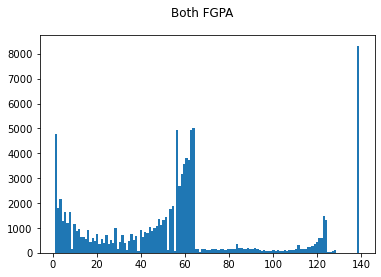

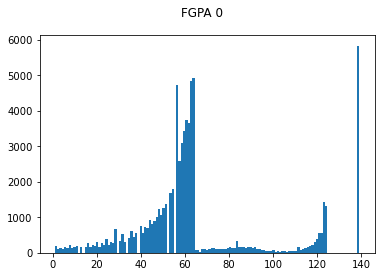

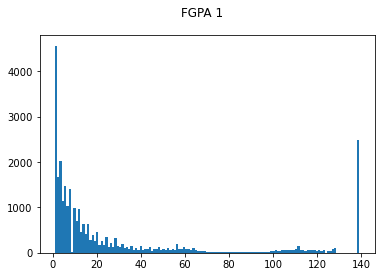

In [59]:
# Point 7
ch = np.unique(data['TDC_CHANNEL'])
n_ch = len(ch)

# Both FPGA
plt.figure(1).suptitle('Both FGPA')
plt.hist(data['TDC_CHANNEL'], bins=n_ch)
plt.show()

fpga0 = data[data['FPGA']==0]
fpga1 = data[data['FPGA']==1]

# FGPA 0
plt.figure(2).suptitle('FGPA 0')
plt.hist(fpga0['TDC_CHANNEL'], bins=n_ch)
plt.show()

# FGPA 1
plt.figure(3).suptitle('FGPA 1')
plt.hist(fpga1['TDC_CHANNEL'], bins=n_ch)
plt.show()

In [77]:
# Point 8
noisy_ch = data.groupby(['TDC_CHANNEL']).count()['HEAD'] #use head column to count channels
noisy_ch = noisy_ch.sort_values(ascending=False)

noisy_ch.head(3)

TDC_CHANNEL
139    8320
64     5027
63     4917
Name: HEAD, dtype: int64

In [84]:
# Point 9
n_orb = np.unique(data['ORBIT_CNT'])

print('Number of unique orbit is:',len(n_orb))

ch139 = data[data['TDC_CHANNEL']==139]
n_orb_139 = np.unique(ch139['ORBIT_CNT'])

print('Number of unique orbit in channel 139:', len(n_orb_139))

Number of unique orbit is: 995
Number of unique orbit in channel 139: 994
